# **Import Library & Requirements**

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.cuda.amp import autocast
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import google.colab.drive as drive
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F  # Importing functional API for softmax

In [ ]:
# Set seed for Python's built-in random module
random.seed(46)

# Set seed for NumPy
np.random.seed(46)

# Set seed for PyTorch (CPU)
torch.manual_seed(46)

# If using GPU, also set the seed for CUDA
torch.cuda.manual_seed(46)
torch.cuda.manual_seed_all(46)  # If you have multiple GPUs

# Ensure reproducibility in certain PyTorch backends
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# **Read Data**

In [ ]:
# mounting google drive
drive.mount('/content/drive')

Mounted at /content/drive


**Clean Dataset**

In [ ]:
# Load Dataset for training
data = pd.read_csv('/content/drive/MyDrive/Thesis/Dataset/Label Dataset/Training_Dataset_Clean.csv')

In [ ]:
# Load Dataset for testing
data_test = pd.read_csv('/content/drive/MyDrive/Thesis/Dataset/Label Dataset/data_testing_clean.csv')

## **Praprocessing Text**

### **Convert Texts and Labels into List**

**Train Data**

In [ ]:
# Encode labels
le = LabelEncoder()

In [ ]:
# Training
# Extract texts and labels
texts = data['text'].astype(str).tolist()
labels = data['label'].astype(int).tolist()

labels = le.fit_transform(labels)

# Check label distribution
print("Label distribution:", np.bincount(labels))
print("Classes:", le.classes_)

Label distribution: [1000 1000 1000]
Classes: [-1  0  1]


**Test Data**

In [ ]:
# Testing
test_texts = data_test['text'].astype(str).tolist()
test_labels = data_test['label'].astype(int).tolist()

# Encode labels
test_labels = le.fit_transform(test_labels)

# Check label distribution
print("Label distribution_testing:", np.bincount(test_labels))
print("Classes_testing:", le.classes_)

Label distribution_testing: [50 50 50]
Classes_testing: [-1  0  1]


### **Set Tokenizer**

In [ ]:
# Define a dictionary mapping tokenizer names to their respective pretrained models
tokenizer_options = {
    'BioBERT': 'dmis-lab/biobert-base-cased-v1.1',
    'Bio_ClinicalBERT': 'emilyalsentzer/Bio_ClinicalBERT',
    'BERT-base-cased': 'bert-base-cased'
}

# Create a dropdown widget
tokenizer_dropdown = widgets.Dropdown(
    options=list(tokenizer_options.keys()),
    description='Select Tokenizer:',
    style={'description_width': 'initial'}  # Adjust description width if needed
)

# Display the dropdown
display(tokenizer_dropdown)

# Function to load the selected tokenizer
def load_selected_tokenizer(change):
    selected_tokenizer_name = change['new']
    selected_tokenizer_model = tokenizer_options[selected_tokenizer_name]
    global tokenizer  # Use global keyword to modify the tokenizer variable
    tokenizer = BertTokenizer.from_pretrained(selected_tokenizer_model)
    print(f"Selected Tokenizer: {selected_tokenizer_name} ({selected_tokenizer_model})")

# Observe the dropdown for changes
tokenizer_dropdown.observe(load_selected_tokenizer, names='value')

# Load the default tokenizer (you can change this)
tokenizer = BertTokenizer.from_pretrained(tokenizer_options['BERT-base-cased'])
print("Default Tokenizer: BERT-base-cased")

Dropdown(description='Select Tokenizer:', options=('BioBERT', 'Bio_ClinicalBERT', 'BERT-base-cased'), style=De…

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Default Tokenizer: BERT-base-cased


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Selected Tokenizer: BERT-base-cased (bert-base-cased)


In [ ]:
# Prepare data for PyTorch
def encode(texts, tokenizer, max_length):
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

### **Visualization as A Basis For Decision Making on The Maximum Sequence Length Parameter**

In [ ]:
# tokens = tokenizer.encode(text, add_special_tokens=True)
# print(len(tokens))
# Calculate token lengths
# token_lens = []
# for txt in tqdm(texts, desc="Calculating token lengths"):
#     tokens = tokenizer.encode(txt, add_special_tokens=True)
#     token_lens.append(len(tokens))

# # Plot token length distribution
# plt.hist(token_lens, bins=50)
# plt.xlabel('Token Length')
# plt.ylabel('Number of Samples')
# plt.title('Distribution of Token Lengths')
# plt.show()

# # Set max_length to cover 95% of the data
# max_length_token = int(np.percentile(token_lens, 95))
# print(f"Selected max_length: {max_length_token}")

### **Set Maximum Sequence Lenght Parameter**

In [ ]:
# TRAINING
# Tokenize the training texts
encoded_inputs = encode(texts, tokenizer, 182)
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

In [ ]:
#TESTING
encoded_inputs_test = encode(test_texts, tokenizer, 182)
test_input_ids = encoded_inputs_test['input_ids']
test_attention_masks = encoded_inputs_test['attention_mask']

### **Convert Data into Tensors**

In [ ]:
# TRAINING
# Convert labels to tensors
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42, stratify=labels
)

# Create datasets and dataloaders
BATCH_SIZE = 32

train_dataset = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
val_dataset = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))

def seed_worker(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, worker_init_fn=seed_worker)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, worker_init_fn=seed_worker)

In [ ]:
# TESTING
# Convert labels to tensors
test_labels = torch.tensor(test_labels)

# If you want to keep the dataset structure similar to your training set
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# **Training Models**

## **BERT**

In [ ]:
class BERTFineTuned(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(BERTFineTuned, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        # Return logits for training and probabilities for inference
        return logits

    def predict(self, input_ids, attention_mask):
        # Forward pass to get logits
        logits = self.forward(input_ids, attention_mask)
        # Apply Softmax to convert logits to probabilities
        probabilities = F.softmax(logits, dim=1)
        return probabilities

In [ ]:
# Initialize model
model = BERTFineTuned(dropout_rate=0.4)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

## **BioBERT**

In [ ]:
class BioBERTFineTuned(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(BERTFineTuned, self).__init__()
        self.bert = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        # Return logits for training and probabilities for inference
        return logits

    def predict(self, input_ids, attention_mask):
        # Forward pass to get logits
        logits = self.forward(input_ids, attention_mask)
        # Apply Softmax to convert logits to probabilities
        probabilities = F.softmax(logits, dim=1)
        return probabilities

In [ ]:
# Initialize model
model = BioBERTFineTuned(dropout_rate=0.4)

## **Bio+Clinical BERT**

In [ ]:
class Bio_clinical_BERTFineTuned(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(BERTFineTuned, self).__init__()
        self.bert = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        # Return logits for training and probabilities for inference
        return logits

    def predict(self, input_ids, attention_mask):
        # Forward pass to get logits
        logits = self.forward(input_ids, attention_mask)
        # Apply Softmax to convert logits to probabilities
        probabilities = F.softmax(logits, dim=1)
        return probabilities

In [ ]:
# Initialize model
model = Bio_clinical_BERTFineTuned(dropout_rate=0.4)

## **Train**

In [ ]:
# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Print the architecture of models
model.to(device)

cuda


BERTFineTuned(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
# # Function to save the best model checkpoint
# def save_checkpoint(model, optimizer, epoch, best_val_f1, tokenizer, file_path='best_model_checkpoint.pth'):
#     checkpoint = {
#         'epoch': epoch,  # Save current epoch
#         'model_state_dict': model.state_dict(),  # Save model parameters
#         'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state
#         'best_val_f1': best_val_f1,  # Save best validation F1-score
#         'learning_rate': 3e-5,  # Save hyperparameters, adjust based on your setup
#         'batch_size': 32,       # Save batch size
#         'dropout_rate': 0.4,    # Save dropout rate or any other hyperparameters
#         # You might not want to save the tokenizer in the checkpoint directly
#     }
#     torch.save(checkpoint, file_path)

#     # Save the tokenizer separately
#     tokenizer_save_path = os.path.join(os.path.dirname(file_path), 'tokenizer')
#     tokenizer.save_pretrained(tokenizer_save_path)

#     print(f"Best model saved successfully with validation F1-score: {best_val_f1}")

In [ ]:
# Training loop with model saving
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

best_val_f1 = 0.0  # Initialize best validation F1-score
best_model_path = 'best_model_checkpoint.pth'  # Path to save the best model

EPOCHS = 10

for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(input_ids, attention_mask)

        # Compute loss
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Store predictions and labels for accuracy and F1 calculation
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate training accuracy and F1-score
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_losses.append(total_loss / len(train_dataloader))
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)

    print(f'Epoch {epoch + 1}/{EPOCHS}, Training --- Loss: {train_losses[-1]:.4f}, Accuracy: {train_acc:.4f}, F1-Score: {train_f1:.4f}')

    # Evaluation Phase
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Forward pass
            logits = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(logits, labels)
            total_val_loss += loss.item()

            # Store predictions and labels for accuracy and F1 calculation
            preds = torch.argmax(logits, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    # Calculate validation accuracy and F1-score
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    val_losses.append(total_val_loss / len(val_dataloader))
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    print(f'Epoch {epoch + 1}/{EPOCHS}, Validation --- Loss: {val_losses[-1]:.4f}, Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}')

    # Save the model and tokenizer into a directory
    directory_name = f'Epoch_{epoch + 1}_F1_Training_{train_f1:.4f}_F1_Validation_{val_f1:.4f}'
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Save model
    model_save_path = os.path.join(directory_name, 'model.pth')
    torch.save(model.state_dict(), model_save_path)

    # Save tokenizer
    tokenizer_save_path = os.path.join(directory_name, 'tokenizer')
    tokenizer.save_pretrained(tokenizer_save_path)

    print(f'Model and tokenizer saved in directory: {directory_name}')

    # Save the best model based on validation F1-score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        # save_checkpoint(model, optimizer, epoch, best_val_f1, tokenizer, best_model_path)  # Save the best model
        print(f'Best model updated at epoch {epoch + 1} with validation F1-score: {best_val_f1:.4f}')

Epoch 1/10, Training --- Loss: 0.8751, Accuracy: 0.5887, F1-Score: 0.5897
Epoch 1/10, Validation --- Loss: 0.4772, Accuracy: 0.8400, F1-Score: 0.8416
Model and tokenizer saved in directory: Epoch_1_F1_Training_0.5897_F1_Validation_0.8416
Best model updated at epoch 1 with validation F1-score: 0.8416
Epoch 2/10, Training --- Loss: 0.3978, Accuracy: 0.8612, F1-Score: 0.8612
Epoch 2/10, Validation --- Loss: 0.3483, Accuracy: 0.8600, F1-Score: 0.8587
Model and tokenizer saved in directory: Epoch_2_F1_Training_0.8612_F1_Validation_0.8587
Best model updated at epoch 2 with validation F1-score: 0.8587
Epoch 3/10, Training --- Loss: 0.2281, Accuracy: 0.9196, F1-Score: 0.9195
Epoch 3/10, Validation --- Loss: 0.3831, Accuracy: 0.8550, F1-Score: 0.8556
Model and tokenizer saved in directory: Epoch_3_F1_Training_0.9195_F1_Validation_0.8556
Epoch 4/10, Training --- Loss: 0.1402, Accuracy: 0.9508, F1-Score: 0.9508
Epoch 4/10, Validation --- Loss: 0.3347, Accuracy: 0.8833, F1-Score: 0.8842
Model and 

## **Evaluation**

### **Data Validation**


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       200
           1       0.98      0.93      0.95       200
           2       0.85      0.85      0.85       200

    accuracy                           0.88       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.88      0.88       600



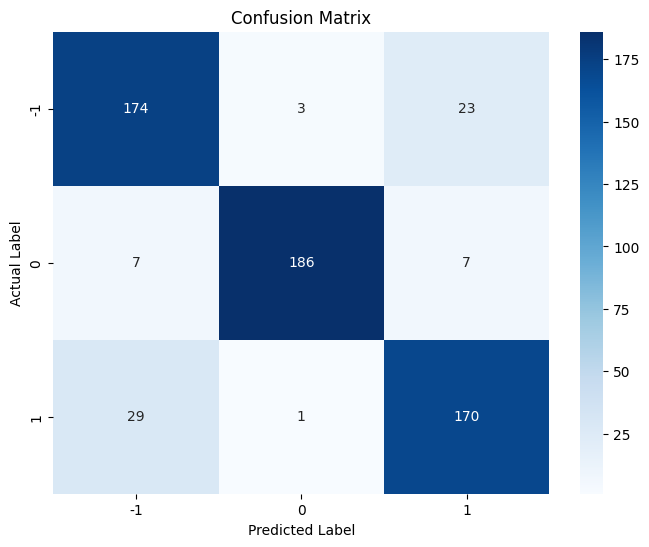

In [ ]:
# Path where the best model is saved
best_model_path = '/content/Epoch_4_F1_Training_0.9508_F1_Validation_0.8842/model.pth'

# Load the checkpoint (the state_dict directly)
checkpoint = torch.load(best_model_path, weights_only=True)

# Load the model state dictionary
model.load_state_dict(checkpoint) # Changed this line to load the checkpoint directly
model.eval()  # Set the model to evaluation mode

# Evaluate the best model on the validation set
all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        logits = model(input_ids, attention_mask)

        # Get predictions
        preds = torch.argmax(logits, dim=1)

        # Store predictions and true labels
        all_val_preds.extend(preds.cpu().numpy())
        all_val_labels.extend(labels.cpu().numpy())

class_report = classification_report(all_val_labels, all_val_preds)

print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(all_val_labels, all_val_preds) # Calculate confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

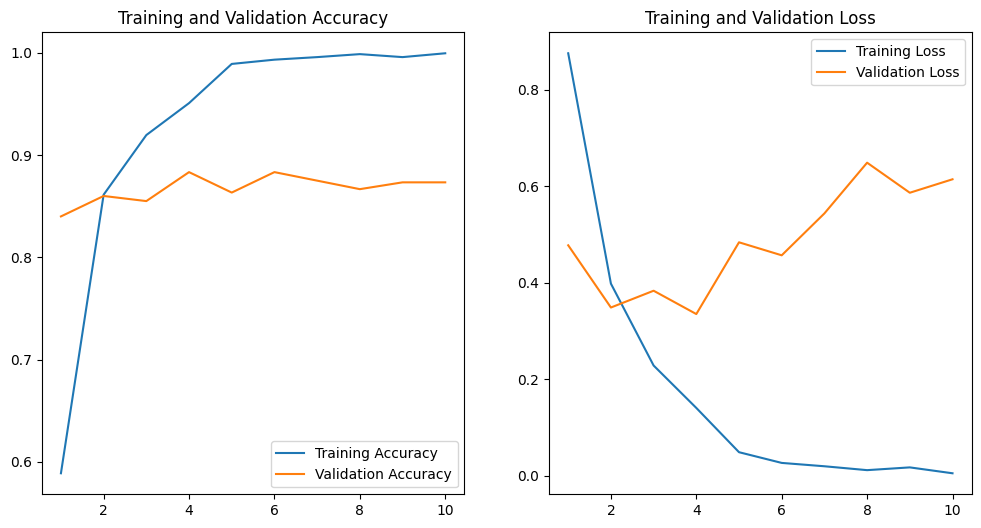

In [ ]:
# Visualize training/validation accuracy and loss
epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### **Data Testing**


Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.86      0.62        50
           1       0.98      0.90      0.94        50
           2       0.44      0.14      0.21        50

    accuracy                           0.63       150
   macro avg       0.63      0.63      0.59       150
weighted avg       0.63      0.63      0.59       150



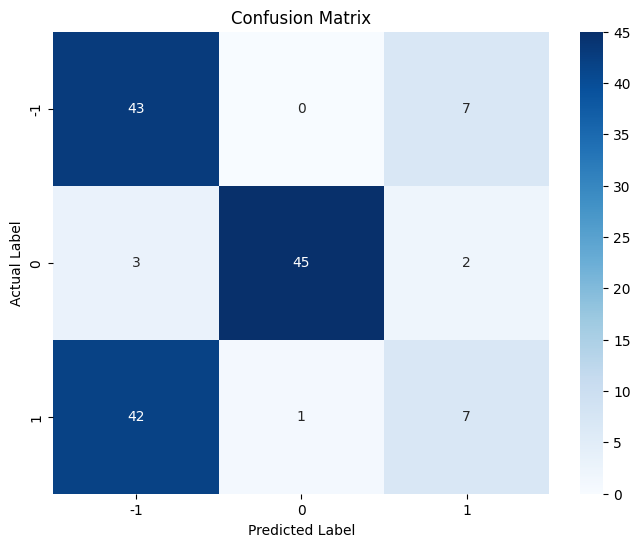

In [ ]:
# Path where the best model is saved
best_model_path = '/content/Epoch_4_F1_Training_0.9508_F1_Validation_0.8842/model.pth'

# Load the checkpoint (the state_dict directly)
checkpoint = torch.load(best_model_path, weights_only=True)

# Load the model state dictionary
model.load_state_dict(checkpoint) # Changed this line to load the checkpoint directly
model.eval()  # Set the model to evaluation mode

# Ensure your test data is on the right device (CPU or GPU)
test_input_ids = test_input_ids.to(device)
test_attention_masks = test_attention_masks.to(device)
test_labels = torch.tensor(test_labels).to(device)

# Perform evaluation on the test data
with torch.no_grad():
    # Forward pass for the entire test set
    logits = model(test_input_ids, attention_mask=test_attention_masks)

    # Get predictions (the class with the highest score)
    test_preds = torch.argmax(logits, dim=1)

# Move predictions and true labels back to CPU and convert to numpy for further analysis
test_preds = test_preds.cpu().numpy()
test_labels = test_labels.cpu().numpy()

# Classification report
class_report = classification_report(test_labels, test_preds)
print("\nClassification Report:\n", class_report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Optionally, visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predict_df = pd.DataFrame({
    'Text': test_texts,
    'True Label': test_labels,
    'Predicted Label': test_preds
})

In [ ]:
predict_df['True Label'] = predict_df['True Label'].replace({0: -1, 1: 0, 2: 1})
predict_df['Predicted Label'] = predict_df['Predicted Label'].replace({0: -1, 1: 0, 2: 1})

In [ ]:
predict_df

,Text,True Label,Predicted Label
0,"feeling tired after that marathon, but it's no...",0,0
1,"i had a cough all day, probably from the dusty...",0,0
2,headache again... must be from staring at scre...,0,0
3,lost my taste buds after eating that extra spi...,0,0
4,fatigue is real after pulling an all-nighter f...,0,0
...,...,...,...
145,"it’s been a year since i had covid, but my sen...",2,2
146,muscle pain and fatigue have been my constant ...,2,2
147,i still can’t believe how much energy i’ve los...,2,2
148,the lingering sore throat from my covid infect...,2,2


### **Custom Texts**

In [ ]:
# Custom text data (replace this with your own)
custom_texts = ["i have a headache because of thinking about my friend #longcovid",
                "i have joint pain and shortness of breath, and cough because my friend said something bad to me #longcovid",
                "my daughter have #longcovid symptoms. i hope she gets well soon",
                "i have long covid, i feel breathlessness and sometimes feel dizziness #longcovid",
                "long covid makes you more healthy",
                "do i have brainfog or i just need more drink?",
                "hey everyone, it’s been a tough few months. ever since i recovered from covid-19, i’ve been dealing with constant fatigue and brain fog. it’s like my energy just vanished. anyone else experiencing this? #longcovid #fatigue",
                "i thought i was over covid, but the lingering symptoms are relentless. my sense of smell and taste are still off, and i get these random bouts of dizziness. it’s affecting my daily life so much. #longcovid #healthstruggles",
                "just wanted to share an update. post-covid, i’ve been having severe joint pain and shortness of breath. it’s been hard to keep up with my usual activities. anyone found any effective treatments? #longcovid #chronicpain",
                "A 45-year-old female presents with a persistent cough, shortness of breath, and fatigue, which have been ongoing for three weeks. She reports that the cough has worsened over time, and she experiences shortness of breath, particularly during physical activity. She also feels unusually fatigued. Her medical history is unremarkable, and she is a non-smoker with no known allergies. On physical examination, her vital signs are within normal limits: blood pressure is 120/80 mmHg, heart rate is 85 bpm, respiratory rate is 20 breaths per minute, and temperature is 98.6°F. Respiratory examination reveals wheezing in both lungs and decreased breath sounds in the lower lobes, while cardiovascular examination shows normal heart sounds with no murmurs. The assessment suggests possible bronchitis or early-stage pneumonia, and further diagnostic tests, including a chest X-ray and sputum culture, are recommended."
                ]

# Preprocess the custom text: Tokenize and encode
def encode_custom_texts(custom_texts, tokenizer, max_length):
    encoded_inputs = tokenizer(
        custom_texts,
        add_special_tokens=True,
        max_length=max_length,  # Use the same max_length as training
        truncation=True,
        padding='max_length',
        return_tensors='pt',  # Return as PyTorch tensors
        return_attention_mask=True
    )
    return encoded_inputs

# Encode the custom texts
encoded_custom_texts = encode_custom_texts(custom_texts, tokenizer, 128)
input_ids_custom = encoded_custom_texts['input_ids']
attention_mask_custom = encoded_custom_texts['attention_mask']

# Move tensors to the appropriate device (GPU or CPU)
input_ids_custom = input_ids_custom.to(device)
attention_mask_custom = attention_mask_custom.to(device)

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set to evaluation mode

# Perform prediction
with torch.no_grad():
    logits = model(input_ids_custom, attention_mask_custom)

# Get predicted labels (taking the argmax of logits to get class with highest probability)
predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()

# Decode the predicted labels to their corresponding class names
predicted_classes = le.inverse_transform(predicted_labels)

# Output the predictions
for text, label in zip(custom_texts, predicted_classes):
    print(f"Text: {text}\nPredicted Label: {label}\n")

## **Saving the model**

In [ ]:
from google.colab import files

def download_directory(directory_path, zip_filename='colab_files.zip'):
  """Downloads a directory as a zip file from Google Colab."""
  !zip -r {zip_filename} {directory_path}
  files.download(zip_filename)

# Example usage:
# Replace 'your_directory_path' with the actual path to the directory you want to download.
download_directory('/content/Epoch_2_F1_Training_0.8612_F1_Validation_0.8587')

  adding: content/Epoch_2_F1_Training_0.8612_F1_Validation_0.8587/ (stored 0%)
  adding: content/Epoch_2_F1_Training_0.8612_F1_Validation_0.8587/tokenizer/ (stored 0%)
  adding: content/Epoch_2_F1_Training_0.8612_F1_Validation_0.8587/tokenizer/tokenizer_config.json (deflated 75%)
  adding: content/Epoch_2_F1_Training_0.8612_F1_Validation_0.8587/tokenizer/special_tokens_map.json (deflated 42%)
  adding: content/Epoch_2_F1_Training_0.8612_F1_Validation_0.8587/tokenizer/vocab.txt (deflated 49%)
  adding: content/Epoch_2_F1_Training_0.8612_F1_Validation_0.8587/model.pth (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>